In [1]:
using PauliPropagation
using Random
using Optim
using Plots
using ReverseDiff: GradientTape, gradient!, compile, gradient
using LinearAlgebra
using StatsBase 
using GLM
using DataFrames
using CSV
using Format
using Logging

# CDR for quantum dynamics
- TFIM Hamiltonian (constants not site-dependent) evolving with TDSE
- discretize the evolution steps and use first-order Trotter decomposition 

### Idea:
- DONE: Run "exact" evolution for small trotterized circuit
- DONE: Create near-Clifford circuits:replace some gates in Trotterized gate by close Cliffords - no VQA here so this is much simpler, find closest Clifford to the RZZ and to the RX (only have 2 angles in total), replace a portion randomly (no MCMC), keep the parameter of N = non-Cliffords const. st. system remains cl. scalable.
- create MWE of CDR within quantum dynamics
- which gates ones we replace has influence on the accuracy of the expectation value (principle of causal light cone as seen in vnCDR paper Piotr, is this automatically respected within Heisenberg picture? (backprop observable)), so we can aim to replace only gates that contribute to an expectation value (works only for single-qubit / local observables)
- another idea is to try the perturbation approach (all non-Cliffords) 



In [2]:
# identic in both
struct trotter_ansatz_tfim
    target_circuit::Vector{Gate}
    target_circuit_layer::Vector{Gate}
    topology::Vector{Tuple{Int64, Int64}}
    nqubits::Integer
    steps::Integer #layers
    time::Integer
    J::Float64
    h::Float64
    sigma_J::Float64
    sigma_h::Float64
    sigma_J_indices::Vector{Int64}
    sigma_h_indices::Vector{Int64}
    sigma_J_indices_layer::Vector{Int64}
    sigma_h_indices_layer::Vector{Int64}
end

# took trotter version (trotter_ansatz_tfim instead of trotter_ansatz in the return)
function trotter_setup(nqubits::Integer, steps::Integer, time::Float64, J::Float64, h::Float64;topology = nothing)
    if isnothing(topology)
        topology = bricklayertopology(nqubits)
    end
    target_circuit = tfitrottercircuit(nqubits,steps,topology=topology) #start with RZZ layer
    target_circuit_layer = tfitrottercircuit(nqubits,1,topology=topology) #start with RZZ layer
    sigma_J = -2*T*J/steps
    sigma_h = 2*T*h/steps 

    sigma_J_indices = getparameterindices(target_circuit, PauliRotation, [:Z,:Z]) 
    sigma_h_indices = getparameterindices(target_circuit, PauliRotation, [:X])
    
    sigma_J_indices_layer = getparameterindices(target_circuit_layer, PauliRotation, [:Z,:Z])
    sigma_h_indices_layer = getparameterindices(target_circuit_layer, PauliRotation, [:X])
    
    return trotter_ansatz_tfim(target_circuit,target_circuit_layer, topology, nqubits, steps, time, J, h,sigma_J, sigma_h,sigma_J_indices, sigma_h_indices, sigma_J_indices_layer, sigma_h_indices_layer)
end

trotter_setup (generic function with 1 method)

In [3]:
# trotter version improved
function constrain_params(ansatz; layer=false)
    """
    Set all RX gates and all RZZ gates to have the same parameter value respectively.
    """
    if layer
        nparams = countparameters(ansatz.target_circuit_layer)
        thetas = zeros(nparams)
        thetas[ansatz.sigma_h_indices_layer] .= ansatz.sigma_h
        thetas[ansatz.sigma_J_indices_layer] .= ansatz.sigma_J
    else
        nparams = countparameters(ansatz.target_circuit)
        thetas = zeros(nparams)
        thetas[ansatz.sigma_h_indices] .= ansatz.sigma_h
        thetas[ansatz.sigma_J_indices] .= ansatz.sigma_J
    end
    
    return thetas
end

constrain_params (generic function with 1 method)

In [4]:
# identic in both
function obs_magnetization(ansatz)
    """
    Returns the normalised magnetization.
    """
    magnetization = PauliSum(ansatz.nqubits)
    for i in 1:nq
        add!(magnetization,:Z,i)
    end
    magnetization = magnetization/nq
    return magnetization
end

obs_magnetization (generic function with 1 method)

In [5]:
# delete training_set_generation and keep training_set_generation_brut only, putting pi/4 as the angle definition by default (equivalent to training_set_generation)
function training_set_generation_brut(ansatz::trotter_ansatz_tfim, angle_definition::Float64=pi/4; num_samples::Int = 10, non_cliffs::Int = 30)
    """
    Generates a training set of thetas for the ansatz. The training set is generated by selecting a number of cliffords and non-cliffords
    and setting the corresponding thetas to multiples of angle_definition. 
    """
    nparams = countparameters(ansatz.target_circuit)
    cliffs = nparams - non_cliffs
    ratio = length(ansatz.sigma_J_indices)/(length(ansatz.sigma_h_indices)+length(ansatz.sigma_J_indices))
    num_h = Int(round((1-ratio)*cliffs))
    num_J = Int(round(ratio*cliffs))
    training_thetas_list = Vector{Vector{Float64}}()
    thetas = constrain_params(ansatz)
    for _ in 1:num_samples
        training_thetas = deepcopy(thetas)
        shuffled_sigma_h_indices =  Random.shuffle!(ansatz.sigma_h_indices)
        shuffled_sigma_J_indices = Random.shuffle!(ansatz.sigma_J_indices)
        selected_indices_h = shuffled_sigma_h_indices[1:num_h]
        selected_indices_J = shuffled_sigma_J_indices[1:num_J];   
        k_h =round(ansatz.sigma_h/(angle_definition))
        k_J =round(ansatz.sigma_J/(angle_definition))

        for i in selected_indices_h
            training_thetas[i] = k_h*angle_definition
        end
        for i in selected_indices_J
            training_thetas[i] = k_J*angle_definition
        end
        push!(training_thetas_list, training_thetas)
    end
    return training_thetas_list
end

training_set_generation_brut (generic function with 2 methods)

In [6]:
# called exact_trotter_time_evolution in trotter, merge for the record part otherwise trotter_perturbation
function trotter_time_evolution(ansatz; special_thetas=nothing, noise_kind="noiseless", record=false, min_abs_coeff=0.0, depol_strength=0.01, dephase_strength=0.01)
    """
    Function that computes the time evolution of the ansatz using the first order Trotter approximation exact time evolution operator.
    The function returns the overlap of the final state with the |0> state.
    """
    if special_thetas==nothing
        thetas = constrain_params(ansatz)#,layer=record)
    else
        thetas = special_thetas
    end
    obs = obs_magnetization(ansatz)

    if noise_kind=="naive"
        if record
            error("Naive noise model doesn't support recording :(")
        else
            circuit = final_noise_layer_circuit(ansatz; depol_strength, dephase_strength)
        end
    elseif noise_kind=="gate"
        circuit = gate_noise_circuit(ansatz; depol_strength, dephase_strength, layer=record)
    elseif noise_kind=="noiseless"
        if record
            circuit = copy(ansatz.target_circuit_layer)
        else
            circuit = copy(ansatz.target_circuit)
        end
    else
        error("Noise kind $noise_kind unknown.")
    end

    if record
        nparams = countparameters(ansatz.target_circuit)
        expvals_trotter = Float64[]   
        push!(expvals_trotter, overlapwithzero(obs))
        for i in 1:ansatz.steps
            psum = propagate!(circuit, obs, thetas[Int(nparams/ansatz.steps*(i-1)+1):Int(nparams/ansatz.steps*i)])
            push!(expvals_trotter, overlapwithzero(psum))
        end
        return expvals_trotter  
    else 
        psum = propagate!(circuit, obs,  thetas)
        return overlapwithzero(psum)
    end
end

trotter_time_evolution (generic function with 1 method)

In [7]:
# exact_time_evolution in trotter, added recording to the trotter_perturbation version
function training_trotter_time_evolution(ansatz, training_thetas; noise_kind="noiseless", min_abs_coeff=0.0, depol_strength=0.01, dephase_strength=0.01, record=false)
    """
    Function that computes the time evolution of the ansatz using the first order Trotter approximation exact time evolution operator.
    The function returns the overlap of the final state with the |0> state.
    """
    if record 
        exact_expvals = Vector{Vector{Float64}}()
    else
        exact_expvals = Vector{Float64}()
    end
    for thetas in training_thetas
        push!(exact_expvals, trotter_time_evolution(ansatz; record=record, special_thetas=thetas, noise_kind=noise_kind, min_abs_coeff=min_abs_coeff, depol_strength=depol_strength, dephase_strength=dephase_strength))
    end
    return exact_expvals
end

training_trotter_time_evolution (generic function with 1 method)

In [8]:
# from trotter
function final_noise_layer_circuit(ansatz; depol_strength=0.05, dephase_strength=0.05)
    """
    Function that adds a final layer of depolarizing and dephasing noise to the ansatz.
    """
    depol_noise_layer = [DepolarizingNoise(qind, depol_strength ) for qind in 1:ansatz.nqubits];
    dephase_noise_layer = [DephasingNoise(qind, dephase_strength) for qind in 1:ansatz.nqubits];
    noisy_circuit = deepcopy(ansatz.target_circuit)
    append!(noisy_circuit,depol_noise_layer)
    append!(noisy_circuit,dephase_noise_layer)

    return noisy_circuit
end

# cleaned from trotter
function gate_noise_circuit(ansatz; depol_strength=0.01, dephase_strength=0.01, start_with_ZZ=true, layer=false)
    """
    Noise model from the CPA paper, where we add a layer of depolarizing and dephasing noise after each step/layer of the ansatz.
    """
    circuit::Vector{Gate} = []
    if layer
        steps = 1
    else
        steps = ansatz.steps
    end

    # the function after this expects a circuit with at least one layer and will always append something
    if steps<1
        error("The number of steps should be at least 1 (steps=$steps).")
    end

    depol_noise_layer = [DepolarizingNoise(qind, depol_strength ) for qind in 1:ansatz.nqubits];
    phase_damp_layer = [DephasingNoise(qind, dephase_strength) for qind in 1:ansatz.nqubits];

    if start_with_ZZ
        rzzlayer!(circuit, ansatz.topology)
        append!(circuit, depol_noise_layer)
        append!(circuit, phase_damp_layer)
    end

    for _ in 1:steps-1
        rxlayer!(circuit, ansatz.nqubits)
        append!(circuit, depol_noise_layer)
        append!(circuit, phase_damp_layer)
        rzzlayer!(circuit, ansatz.topology)
        append!(circuit, depol_noise_layer)
        append!(circuit, phase_damp_layer)
    end

    rxlayer!(circuit, ansatz.nqubits)
    append!(circuit, depol_noise_layer)
    append!(circuit, phase_damp_layer)

    if !start_with_ZZ
        rzzlayer!(circuit, ansatz.topology)
        append!(circuit, depol_noise_layer)
        append!(circuit, phase_damp_layer)
    end

    return circuit
end

gate_noise_circuit (generic function with 1 method)

In [9]:
# from trotter_perturbation
function cdr(noisy_exp_values::Vector{Float64}, exact_exp_values::Vector{Float64}, noisy_target_exp_value::Float64, exact_target_exp_value::Float64)
    training_data = DataFrame(x=noisy_exp_values,y=exact_exp_values)
    ols = lm(@formula(y ~ x), training_data)
    function cdr_em(x)
        return  coef(ols)[1] + coef(ols)[2] * x
    end
    rel_error_after = abs(exact_target_exp_value - cdr_em(noisy_target_exp_value)) / abs(exact_target_exp_value)
    rel_error_before = abs(exact_target_exp_value - noisy_target_exp_value) / abs(exact_target_exp_value)
    # if verbose
    #     println(training_data)
    #     println("Noisy target expectation value: ", noisy_target_exp_value)
    #     println("Relative error before CDR: ", rel_error_before)
    #     println("CDR-EM target expectation value: ", cdr_em(noisy_target_exp_value))
    #     println("Relative error after CDR: ", rel_error_after)
    # end
    @debug training_data
    @debug "Noisy target expectation value: " noisy_target_exp_value
    @debug "Relative error before CDR: " rel_error_before
    @debug "CDR-EM target expectation value: " cdr_em(noisy_target_exp_value)
    @debug "Relative error after CDR: " rel_error_after
    return cdr_em(noisy_target_exp_value), rel_error_after, rel_error_before
end 

cdr (generic function with 1 method)

In [56]:
# from trotter_perturbation
function full_run(ansatz, angle_definition, noise_kind, min_abs_coeff, min_abs_coeff_noisy; num_samples=10, non_cliffs=30)
    @logmsg SubInfo "ready to ruuuuuummmble"

    time1 = time()
    exact_expval_target = trotter_time_evolution(ansatz; noise_kind="noiseless") #should be close to one as we stay in FM phase
    timetmp1 = time()
    @logmsg SubInfo "exact_expval_target done in $(round(timetmp1-time1; digits = 2)) s"

    noisy_expval_target = trotter_time_evolution(ansatz; noise_kind=noise_kind)
    timetmp2 = time()
    @logmsg SubInfo "noisy_expval_target done in $(round(timetmp2-timetmp1; digits = 2)) s"
    timetmp1 = timetmp2
    
    angle_definition = pi/8
    training_set = training_set_generation_brut(ansatz, angle_definition; num_samples=num_samples, non_cliffs=non_cliffs); 
    timetmp2 = time()
    @logmsg SubInfo "training_set_generation_brut done in $(round(timetmp2-timetmp1; digits = 2)) s"
    timetmp1 = timetmp2
    
    
    exact_expvals = training_trotter_time_evolution(ansatz, training_set; noise_kind="noiseless", min_abs_coeff=min_abs_coeff_noisy);
    timetmp2 = time()
    @logmsg SubInfo "training_exact_time_evolution_brut done in  $(round(timetmp2-timetmp1; digits = 2)) s"
    timetmp1 = timetmp2
    
    noisy_expvals = training_trotter_time_evolution(ansatz, training_set; noise_kind=noise_kind, min_abs_coeff=min_abs_coeff_noisy);
    timetmp2 = time()
    @logmsg SubInfo "noisy_time_evolution_brut done in  $(round(timetmp2-timetmp1; digits = 2)) s"
    timetmp1 = timetmp2
    
    corr_energy, rel_error_after, rel_error_before = cdr(noisy_expvals, exact_expvals, noisy_expval_target[1], exact_expval_target)  
    timetmp2 = time()
    @logmsg SubInfo "cdr done in  $(round(timetmp2-timetmp1; digits=2)) s"

    @logmsg MainInfo "nq=$(ansatz.nqubits) noise=$noise_kind total run done in $(round(timetmp2-time1; digits=2)) s"

    # open file in append mode 
    if noise_kind=="naive"
        log = open("trotter_brut_naive.log", "a")  
    elseif noise_kind=="gate"
        log = open("trotter_brut_gate.log", "a")
    else
        error("Noise kind $noise_kind unknown.")
    end
    str = format("{:>5n} {:>5n} {:>6.2e} {:>10.2e} {:>10.2e} {:>10.2e} {:>10.2e} {:>10.2e} {:>10.2e} {:>10.2e} {:>10.2e} {:>10.2e} {:>10.2e}\n", nq, steps, T, J, h, angle_definition, min_abs_coeff, min_abs_coeff_noisy, exact_expval_target, noisy_expval_target[1], rel_error_before, rel_error_after, timetmp2-time1);
    # writing to a file using write() method  
    write(log, str)  
        
    # We need to close the file in order to write the content from the disk to file  
    close(log)
    return exact_expval_target, noisy_expval_target[1], corr_energy, rel_error_before, rel_error_after
end

full_run (generic function with 1 method)

# MWE
### Exact evolution of a small trotterized circuit (see CPDR p.7)

In [11]:
nq = 4
# heaxy_hex_2_topology = [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), 
# (10, 11), (11, 12), (12, 1), (5, 13), (13, 14), (14, 15), (15, 16), 
# (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 7)]
steps = 200
T = 20.0
J =  5.0 # J > 0 in ferromagnetic phase, J < 0 in antiferromagnetic phase
h = 1.0 #abs(h) < abs(J) in ordered phase

#paramagnetic (h = -2, J =1)
trotter = trotter_setup(nq, steps, T, J, h);
noisy_circuit = gate_noise_circuit(trotter, depol_strength = 0.01, dephase_strength = 0.01);
noisy_circuit_layer = gate_noise_circuit(trotter, depol_strength = 0.01, dephase_strength = 0.01, layer = true);

### Target data

In [12]:
exact_expval_target = trotter_time_evolution(trotter; record=true); #should be close to one as we stay in FM phase

In [13]:
noisy_expval_target = trotter_time_evolution(trotter; noise_kind="gate", record=true);

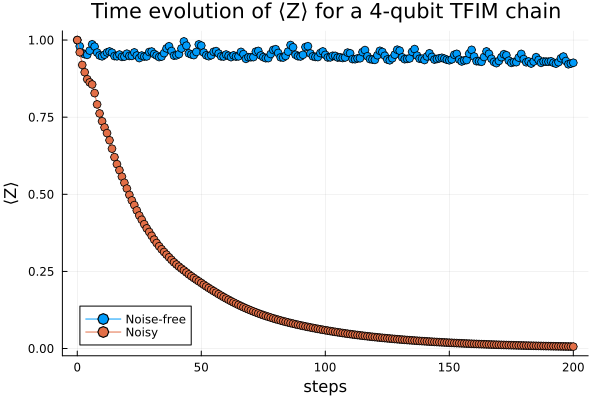

In [14]:
plot(0:trotter.steps,exact_expval_target,
 ylabel="⟨Z⟩", xlabel="steps", label="Noise-free", marker=:o)
plot!(0:trotter.steps, noisy_expval_target, label="Noisy", marker=:o, c=2)
plot!(title = "Time evolution of ⟨Z⟩ for a 4-qubit TFIM chain")

### Training data

In [15]:
list_training_thetas = training_set_generation_brut(trotter; num_samples=10, non_cliffs=30)

10-element Vector{Vector{Float64}}:
 [-0.7853981633974483, -0.7853981633974483, -0.7853981633974483, 0.0, 0.0, 0.0, 0.0, -0.7853981633974483, -0.7853981633974483, -0.7853981633974483  …  0.0, 0.0, 0.0, -0.7853981633974483, -0.7853981633974483, -0.7853981633974483, 0.0, 0.2, 0.0, 0.0]
 [-0.7853981633974483, -0.7853981633974483, -0.7853981633974483, 0.0, 0.0, 0.0, 0.0, -0.7853981633974483, -0.7853981633974483, -0.7853981633974483  …  0.0, 0.0, 0.0, -0.7853981633974483, -0.7853981633974483, -0.7853981633974483, 0.0, 0.0, 0.0, 0.0]
 [-0.7853981633974483, -0.7853981633974483, -0.7853981633974483, 0.0, 0.0, 0.0, 0.0, -0.7853981633974483, -0.7853981633974483, -0.7853981633974483  …  0.0, 0.0, 0.0, -0.7853981633974483, -0.7853981633974483, -0.7853981633974483, 0.0, 0.0, 0.0, 0.0]
 [-0.7853981633974483, -0.7853981633974483, -0.7853981633974483, 0.0, 0.0, 0.0, 0.0, -0.7853981633974483, -0.7853981633974483, -0.7853981633974483  …  0.0, 0.0, 0.0, -0.7853981633974483, -0.7853981633974483, -0.785398

In [16]:
exact_expvals = training_trotter_time_evolution(trotter, list_training_thetas; record=true);
#problem: in the record, we need to take the new corresponding thetas of each layer.

10-element Vector{Vector{Float64}}:
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.9552438633718514, 0.9552438633718514, 0.9552438633718514, 0.9552438633718514, 0.9552438633718514, 0.9552438633718514, 0.9552438633718514, 0.9552438633718514, 0.9552438633718514, 0.9590000556600906]
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.8794736324109981, 0.8794736324109981, 0.8794736324109981, 0.8935763680958857, 0.8935763680958857, 0.8935763680958857, 0.8692309018987124, 0.8692309018987124, 0.8692309018987124, 0.8692309018987124]
 [1.0, 1.0, 0.9950166444603104, 0.9900332889206208, 0.9900332889206208, 0.9900332889206208, 0.9900332889206208, 0.9900332889206208, 0.9900332889206208, 0.9900332889206208  …  0.9165141096021592, 0.9165141096021592, 0.9165141096021592, 0.9165141096021592, 0.9165141096021592, 0.9165141096021592, 0.9165141096021592, 0.9165141096021592, 0.9165141096021592, 0.9165141096021592]
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.9491886072496872, 0.94

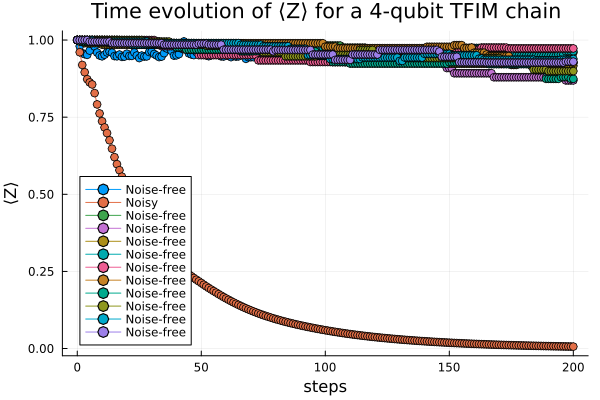

In [17]:
for i in exact_expvals
    plot!(0:trotter.steps,i, label="Noise-free", marker=:o)
end
plot!(xlabel = "steps", ylabel="⟨Z⟩", title = "Time evolution of ⟨Z⟩ for a 4-qubit TFIM chain")

In [18]:
noisy_expvals = training_trotter_time_evolution(trotter, list_training_thetas; noise_kind="gate", record = true);

In [19]:
println(noisy_expvals)

[[1.0, 0.9801, 0.96059601, 0.9414801494009999, 0.92274469442792, 0.9043820750088043, 0.8863848717161291, 0.8687458127689781, 0.8514577710948754, 0.8345137614500874, 0.8179069375972307, 0.8016305895390458, 0.7856781408072188, 0.7700431458051551, 0.7547192872036325, 0.7397003733882802, 0.7249803359578534, 0.7070122879109204, 0.692942743381493, 0.6791531827882012, 0.6656380344507161, 0.6523918375651468, 0.6394092399976004, 0.6266849961216482, 0.6142139646988274, 0.5989761464651051, 0.5870565211504495, 0.5753740963795556, 0.5639241518616024, 0.5527020612395566, 0.5417032902208894, 0.5309233947454935, 0.5203580191900582, 0.510002894608176, 0.49985383700547337, 0.48990674564906445, 0.4777407169788906, 0.4682336767110107, 0.4589158265444616, 0.4497834015962268, 0.44083271190446194, 0.43206014093756306, 0.42346214413290556, 0.41503524746466075, 0.40677604604011397, 0.3986812027239158, 0.39074744678970985, 0.3829715725985946, 0.3753504383038826, 0.36783659244729605, 0.36051664425759483, 0.35334

In [20]:
noisy_circ = gate_noise_circuit(trotter, depol_strength = 0.01, dephase_strength = 0.01);

In [21]:
exact_expvals_cdr = training_trotter_time_evolution(trotter, list_training_thetas; record=false);
noisy_expvals_cdr = training_trotter_time_evolution(trotter, list_training_thetas; noise_kind="gate", record = false);
corr_energy, rel_error_after, rel_error_before = cdr(noisy_expvals_cdr, exact_expvals_cdr, noisy_expval_target[end], exact_expval_target[end])  

(0.3101489248526863, 0.6651985622040428, 0.9932381414411473)

## Trying to make CDR work

In [ ]:
# some fancy log from ChatGPT
struct UnbufferedLogger <: Logging.AbstractLogger
    stream::IO
    level::Logging.LogLevel
end

const MainInfo = Base.CoreLogging.LogLevel(200)
const SubInfo = Base.CoreLogging.LogLevel(100)

const LOG_LEVEL_NAMES = Dict(
    Logging.Debug => "Debug",
    Logging.Info => "Info",
    Logging.Warn => "Warn",
    Logging.Error => "Error",
    SubInfo => "SubInfo",
    MainInfo => "MainInfo"
)

Logging.min_enabled_level(logger::UnbufferedLogger) = logger.level
Logging.shouldlog(logger::UnbufferedLogger, level, _module, group, id) = level ≥ logger.level
Logging.catch_exceptions(::UnbufferedLogger) = true

function Logging.handle_message(logger::UnbufferedLogger, level, message, _module, group, id, file, line)
    level_name = get(LOG_LEVEL_NAMES, level, "$level")  # Default for custom levels
    print(logger.stream, "[$level_name] ", message, "\n")  # Include log level
    flush(logger.stream)  # Ensure immediate output
end

In [ ]:
# Set the unbuffered logger globally
global_logger(UnbufferedLogger(stdout, SubInfo))


nq = 8
steps = 10
angle_definition = pi/8
T = 1.
J = 5.0 #J > 0 in ferromagnetic phase, J < 0 in antiferromagnetic phase
h = 1.0 #abs(h) < abs(J) in ordered phase
# J = 1.0 #J > 0 in ferromagnetic phase, J < 0 in antiferromagnetic phase
# h = -2.0 #abs(h) < abs(J) in ordered phase
trotter = trotter_setup(nq, steps, T, J, h);

noise_kind = "gate"
min_abs_coeff = 1e-10;
min_abs_coeff_noisy = min_abs_coeff;

# with_logger(infologger) do
#     full_run(nq, steps, angle_definition, T, J, h, trotter, noise_kind, min_abs_coeff, min_abs_coeff_noisy)
# end
full_run(trotter, angle_definition, noise_kind, min_abs_coeff, min_abs_coeff_noisy)


[SubInfo] ready to ruuuuuummmble
[SubInfo] exact_expval_target done in 0.08 s
[SubInfo] noisy_expval_target done in 0.18 s
[SubInfo] training_set_generation_brut done in 0.0 s
[SubInfo] training_exact_time_evolution_brut done in  1.39 s
[SubInfo] noisy_time_evolution_brut done in  3.08 s
[SubInfo] cdr done in  0.0 s
[MainInfo] nq=8 noise=gate total run done in 4.73 s



(0.9578665548250215, 0.7295983642404753, 1.090202467782129, 0.2383089684410634, 0.13815694084995164)

In [57]:
global_logger(UnbufferedLogger(stdout, MainInfo))

nqubits = 4
steps = 10
angle_definition = pi/4
T = 1.0
J = 5.0 #J > 0 in ferromagnetic phase, J < 0 in antiferromagnetic phase
h = 1.0 #abs(h) < abs(J) in ordered phase
trotter = trotter_setup(nqubits, steps, T, J, h);
nsamples = 10:10:100

noise_kind = "gate"
min_abs_coeff = 1e-6;
min_abs_coeff_noisy = min_abs_coeff;


rel_err_ratio_gate = []

for nsample=nsamples
    exact_expvals, noisy_expvals, corr_energy, rel_error_before, rel_error_after = full_run(trotter, angle_definition, "gate", min_abs_coeff, min_abs_coeff_noisy; num_samples=nsample)
    push!(rel_err_ratio_gate, rel_error_before/rel_error_after)
end



[MainInfo] nq=4 noise=gate total run done in 0.01 s
[MainInfo] nq=4 noise=gate total run done in 0.01 s
[MainInfo] nq=4 noise=gate total run done in 0.02 s
[MainInfo] nq=4 noise=gate total run done in 0.03 s
[MainInfo] nq=4 noise=gate total run done in 0.03 s
[MainInfo] nq=4 noise=gate total run done in 0.04 s
[MainInfo] nq=4 noise=gate total run done in 0.05 s
[MainInfo] nq=4 noise=gate total run done in 0.08 s
[MainInfo] nq=4 noise=gate total run done in 0.06 s
[MainInfo] nq=4 noise=gate total run done in 0.06 s


In [58]:
df = DataFrame(nqubits = nqubits, rel_err_ratio_gate = rel_err_ratio_gate)
fn = format("data/J={:.2f}_h={:.2f}_T={:.2f}_angdef={:.2f}_steps={:n}_nqubits={:n}_nsamples_{:n}_to_{:n}_minabs={:.2e}_minabsnoisy={:.2e}.csv", J, h, T, angle_definition, steps, nqubits, nsamples[1], nsamples[end], min_abs_coeff, min_abs_coeff_noisy)
CSV.write(fn, df)

"data/J=5.00_h=1.00_T=1.00_angdef=0.79_steps=10_nqubits=4_nsamples_10_to_100_minabs=1.00e-06_minabsnoisy=1.00e-06.csv"

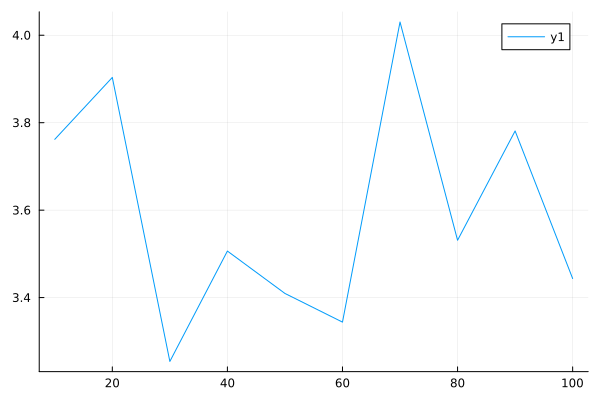

In [59]:
plot(nsamples, rel_err_ratio_gate)
